# Data Processing of Reddit posts 
The purpose of this section is to label each post with all the stock tickers mentioned inside, to explore the ditribution of stock mentions and to preprocess natural language for sentiment analysis.

In [1]:
library(dplyr)
library(tidyverse)
library(quanteda)
library(quanteda.textstats)
library(quanteda.textplots)

ERROR: Error in parse(text = x, srcfile = src): <text>:1:1: SPECIAL inatteso
1: %%
    ^


## Data formating 
We have merged 'title' and 'body' into a new 'text' field that includes all text data from posts, we processed dates, and dropped unnecessary columns, we can now proceed with the ticker labeling.

In [2]:
# Reddit/Wallstreetbets posts and comments
wsb <- read.csv(file = "../data/reddit_posts_wsb.csv",
               header = TRUE,
               sep = ",",
               dec = ".")

# Concatenate the 'title' and 'body' columns and store the result in the 'text' column
wsb$text <- paste(wsb$title, ":", wsb$body)

# Convert the 'created' column to a POSIXct object representing timestamps
wsb$timestamp <- as.POSIXct(wsb$created,
                            origin = "1970-01-01")

# Convert the 'timestamp' column to Date format
wsb$timestamp <- as.Date(wsb$timestamp)

# Remove the 'title', 'body', 'url', and 'created' columns from the 'wsb' data frame
wsb <- wsb %>% select(-c(title, body, url, created))

# Historical prices downloaded from Nasdaq
stocks <- read.csv(file = "../data/nasdaq_screener_1647887652553.csv",
                   header = TRUE,
                   sep = ",",
                   dec = ".")


We will then add cryptocurrencies tickers to the list of tickers coming from our stocks dataset, and then we will find tickers in 'text' using a Regex expression. We will also remove tickers that may be mistakenly labeled, like letters such as F or T (Ford, AT&T), words used in common language, and other vocabularies that belong to the WSB language and that may use to address other issues other than expressing an opion about(IBKR and HOOD are two popular brokers, DD stands for Due Diligence, JP/JPM usually used to talk about JP Morgan activity as a bank rather than as a stock).

We can see that the stock mentions follow an exponential distribution with a few stocks mentioned much more than others. Since many stocks lack mentions over all the observed period we will later create an index with the 50 most mentioned stocks. 

In [3]:
# Define regular expression for finding stock and cryptocurrency symbols
reg_expression <- regex(
  paste0("\\b(?:", paste(stocks$Symbol, collapse = "|"),
         "BTC|ETH|DOGE|SHIB|LTC|AVAX|ADA|XPR|USDT|BCH|BSV|EOS|BNB|XTZ|SOL|LUNA|DOT|MATIC|WBTC|DOGECOIN)\\b")
)

# Extract mentioned stock symbols from the 'text' column of 'wsb' data frame
reddit_mentions <- wsb %>%
  mutate(stock_mention = str_extract_all(text, reg_expression)) %>%
  unnest(stock_mention) %>%
  distinct()

# Define false positives: unrelated words recognized as stock symbols
fp <- c("RH", "DD", "CEO", "IMO", "EV", "PM", "TD", "ALL",
        "USA", "IT", "WE", "IS", "YOU", "ON", "ARE", "CAN", "NOW",
        "GET", "ME", "BE", "UK", "GO", "UP", LETTERS, "FOR", "AI",
        "EDIT", "OR", "AM", "RSI", "SO", "OUT", "TA", "BIG", "ONE",
        "HUGE", "HAS", "NEW", "NEXT", "LOVE", "VERY", "BY", "LIVE",
        "LINK", "DTC", "ANY", "PT", "RE", "OI", "OPEN", "ET", "TV",
        "AKA", "PSA", "SKT", "AN", "GOOD", "LOW", "PLAY", "REAL",
        "SEE", "IQ", "IBKR", "RIDE", "APP", "OG", "CASH",
        "FREE", "EVER", "LIFE", "CASH", "MOVE", "III",
        "HOOD", "JP", "JPM")

# Filter out false positives and count the occurrences of each stock mention
mentions <- reddit_mentions %>%
  filter(!(stock_mention %in% fp)) %>%
  group_by(stock_mention) %>%
  count() %>%
  arrange(-n) %>%
  print(n = 50)

# A tibble: 2,073 x 2
# Groups:   stock_mention [2,073]
   stock_mention     n
   <chr>         <int>
 1 GME           12888
 2 AMC            4945
 3 BB             2092
 4 NOK            1559
 5 PLTR            794
 6 RKT             738
 7 TSLA            573
 8 UWMC            399
 9 SNDL            372
10 AMD             365
11 WISH            336
12 CLOV            321
13 SPCE            293
14 SI              231
15 AAPL            227
16 NIO             218
17 TLRY            188
18 CRSR            174
19 CLNE            170
20 AAL             166
21 CLF             165
22 MVIS            157
23 AMZN            152
24 GM              149
25 WKHS            147
26 ASO             133
27 BABA            123
28 BBBY            115
29 DKNG            108
30 NVDA            104
31 MSFT             99
32 FB               98
33 SOFI             94
34 DOGE             93
35 AG               90
36 KOSS             85
37 GE               81
38 POST             78
39 LFG              76
4

Warning message in mean.default(mentions):
"l'argomento non è numerico o logico: si restituisce NA"


[1] NA


ERROR: Error in h(simpleError(msg, call)): errore durante la valutazione dell'argomento 'x' nella selezione di un metodo per la funzione 'print': l'oggetto 'list' non può essere convertito nel tipo 'double'


## NLP

Before performing the sentiment analysis we will proceed with the tokenization of reddit text, we will then keep only the words carrying actual sentiment by removing punctuation, URLs, numbers and symbols.

And since we will perform sentiment analysis via Vader we won't need to capture all of the words context, so we can just reduce words to their base form by stemming.

As we can see in the wordcloud of our corpus most of the most common words are words from finance(hold, sell, market, stock), emoticons like oys(rocket) or slang words from the subreddit like retard(the official nickname of the WSB redditors).  


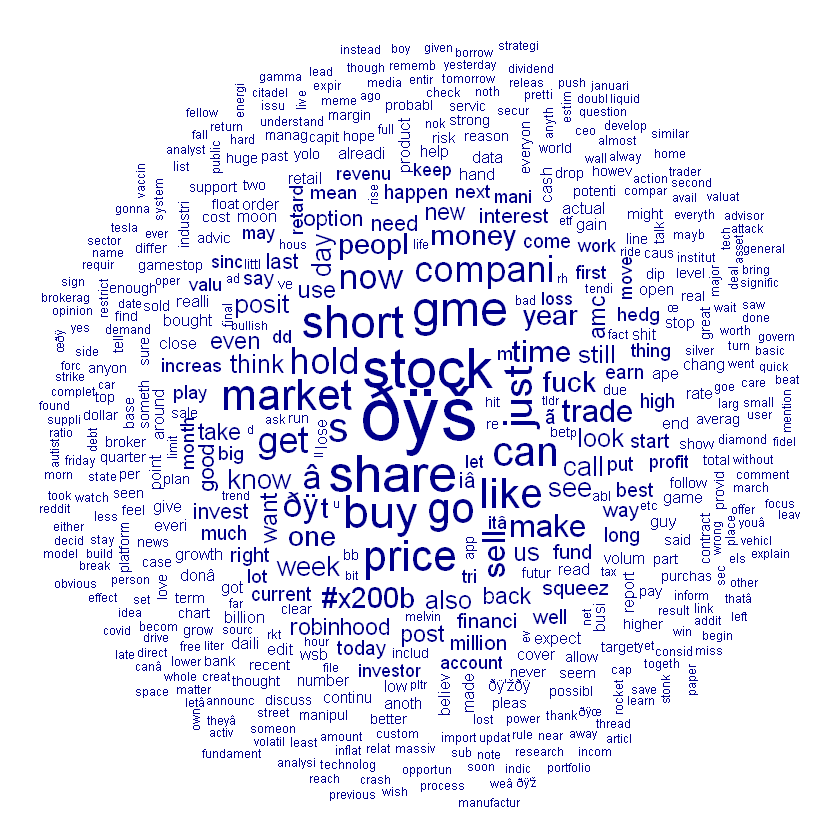

In [19]:
# Select the 'text' column from the 'wsb' data frame
text <- select(wsb, c("text"))

# Remove duplicate texts
text <- distinct(text)

# Create a corpus from the 'text' column
corpus <- corpus(text, text_field = "text")

# Tokenize the corpus, removing numbers, punctuation, symbols, and URLs
token <- tokens(
  corpus,
  remove_numbers = TRUE,
  remove_punct = TRUE,
  remove_symbols = TRUE,
  remove_url = TRUE,
  include_docvars = TRUE
)
# Convert the dfm to TsparseMatrix format
mydfm <- as(mydfm, "TsparseMatrix")

# Create a document-feature matrix (dfm) from the tokens
mydfm <- dfm(token, tolower = TRUE) %>%
  dfm_remove(stopwords("english")) %>%
  dfm_wordstem()

# Calculate term frequency using the dfm
tstat_freq <- textstat_frequency(mydfm)

# Generate a word cloud based on the dfm
textplot_wordcloud(mydfm)
